# BİL 366 Veri Madenciliği Final Ödevi



+ #### Samet Burgazoğlu 19120205017
+ #### Muhammed Furkan Yıldırım 19120205024
+ #### Hüseyin Arda Davulcu 19120205039
+ #### Muhammed Bekir Öztürk 19120205061

&nbsp;

Projemize “Avrupa Birliği'nde kapanma dönemlerindeki hareketlilik değişimlerinin vaka ve ölüm sayılarına etkisi ve hareketlilik - vaka ilişkisinin incelenmesi.” mantalitesi ile başladık. Bu proje ile ülkelerin daha verimli kapanmasını sağlamayı amaçladık. Bu bağlamda önce Avrupa Birliği’ndeki 27 ülkeyi incelediğimizde Kıbrıs (Sanıyoruz ki sadece Güney Kıbrıs Rum Yönetimi kastediliyor ama Avrupa Birliği için sadece Kıbrıs) için veri olmadığını fark ettik. Bu yüzden başta Kıbrıs haricindeki 26 ülkeyi baz almaya karar verdik. Akabinde tam kapanma yapmadıklarından dolayı Letonya, Lüksemburg, Malta, Slovenya ve İsveç’i de listemizden çıkardık.

Geriye kalan ülkeler:

1. Avusturya
1. Belçika
1. Bulgaristan
1. Hırvatistan
1. Çekya
1. Danimarka
1. Estonya
1. Finlandiya
1. Fransa
1. Almanya
1. Yunanistan
1. Macaristan
1. İrlanda
1. İtalya
1. Litvanya
1. Hollanda
1. Polonya
1. Portekiz
1. Romanya
1. Slovakya
1. İspanya

Buraya kadar yaptıklarımızı kod üzerinde gösterelim:

In [40]:
import os
import csv
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data
from lockdown import LockDown

Öncelikle gerekli modüllerimizi import ettik.

In [41]:
all_data = []
dtype = {
    "country_region_code":str,
    "country_region":str,
    "sub_region_1":str,
    "sub_region_2":str,
    "metro_area":str,
    "iso_3166_2_code":str,
    "census_fips_code":str,
    "place_id":str,
    "date":object,
    "retail_and_recreation_percent_change_from_baseline":float,
    "grocery_and_pharmacy_percent_change_from_baseline":float,
    "parks_percent_change_from_baseline":float,
    "transit_stations_percent_change_from_baseline":float,
    "workplaces_percent_change_from_baseline":float,
    "residential_percent_change_from_baseline":float
}
deleted_countries = [
    "LV",  # Letonya
    "LU",  # Lüksemburg
    "MT",  # Malta
    "SI",  # Slovenya
    "SE",  # İsveç
]

sns.set(rc={'figure.figsize':(11.7,8.27)})


Daha sonra bu ülkelerin hareketlilik verilerini Google üzerinden [1](https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip) vaka sayılarını ise WHO üzerinden [2](https://covid19.who.int/WHO-COVID-19-global-data.csv) 15.12.2021 tarihinde edindik. Google, hareketlilik verisini günlük olarak güncellenmediği için elimizdeki en son veriler 12.12.2021 tarihine ait. Verilerin büyüklüğü yüzünden veriyi internet üzerinden değil, bilgisayara kaydedilen dosyalar üzerinden almaya karar verdik.

Kapanma tarihlerini çeşitli kaynaklardan edindik. Kaynaklardaki bazı değerlerin tutarlı olmadığını gördük. Örneğin, tam tarih aldığımız kaynağın kaynağı olan haberde "30.11.2020 tarihine kadar kapanma olacaktır." ibaresi yer alırken aslında kastedilen son kapanma gününün 29.11.2020 tarihi olması gibi durumlara dikkat ettik. Aldığımız kaynak bunu 30.11.2020 olarak almıştı, bu tip durumlarda düzenlemeye gittik. Kapanma tarihlerini edindiğimiz kaynakları kaynakça kısmında belirttik.

Verilerin daha hızlı işlenmesi adına veri tiplerini tutan bir dict nesnesini pandas kütüphanesinin read_csv fonksiyonuna parametre olarak verdik.

Ülkeleri kıyasladığımız için Google verisinde ülkelerin bölgelerine (eyalet, il, ilçe vb.) ait olan verileri göz ardı ettik. Benzer şekilde sub_region_1, sub_region_2, metro_area, iso_3166_2_code, census_fips_code, place_id sütunlarını kaldırdık. WHO verisinden yeni vaka değerlerini alıp ilgili ülkenin uygun tarihli satırına ekledik. 2020 ve 2021 verileri Google datasında ayrı verilse de biz hem onu, hem de tüm ülkeleri tek DataFrame’de topladık. Bu aşamayla ilgili kodlar aşağıdadır:

In [42]:
dropped_columns = [
    'sub_region_1',
    'sub_region_2',
    'metro_area',
    'iso_3166_2_code',
    'census_fips_code',
    'place_id',
]

new_column_names = {
    'retail_and_recreation_percent_change_from_baseline': 'retail_and_recreation',
    'grocery_and_pharmacy_percent_change_from_baseline': 'grocery_and_pharmacy',
    'parks_percent_change_from_baseline': 'parks',
    'transit_stations_percent_change_from_baseline': 'transit_stations',
    'workplaces_percent_change_from_baseline': 'workplaces',
    'residential_percent_change_from_baseline': 'residential',
}

lockdowns_data = [
    ['AT', '16.03.2020', '13.04.2020'],
    ['AT', '03.11.2020', '30.11.2020'],
    ['AT', '26.12.2020', '07.02.2021'],
    ['AT', '22.11.2021', '12.12.2021'],
    ['BE', '18.03.2020', '04.05.2020'],
    ['BE', '02.11.2020', '14.12.2020'],
    ['BE', '27.03.2021', '26.04.2021'],
    ['BG', '13.03.2020', '15.06.2020'],
    ['BG', '28.11.2020', '31.01.2021'],
    ['BG', '22.03.2021', '31.03.2021'],
    ['HR', '18.03.2020', '11.05.2020'],
    ['HR', '22.12.2020', '29.12.2020'],
    ['CZ', '16.03.2020', '12.04.2020'],
    ['CZ', '22.10.2020', '28.03.2021'],
    ['DK', '12.03.2020', '13.04.2020'],
    ['DK', '25.12.2020', '01.03.2021'],
    ['FR', '17.03.2020', '11.05.2020'],
    ['FR', '30.10.2020', '15.12.2020'],
    ['FR', '04.04.2021', '03.05.2021'],
    ['FI', '16.03.2020', '13.05.2020'],
    ['FI', '08.03.2021', '28.03.2021'],
    ['EE', '11.03.2021', '11.04.2021'],
    ['DE', '16.03.2020', '30.05.2020'],
    ['DE', '02.11.2020', '01.03.2021'],
    ['GR', '23.03.2020', '04.05.2020'],
    ['GR', '07.11.2020', '22.03.2021'],
    ['HU', '28.03.2020', '10.04.2020'],
    ['IE', '12.03.2020', '18.05.2020'],
    ['IE', '21.10.2020', '01.12.2020'],
    ['IE', '24.12.2020', '12.04.2021'],
    ['IT', '09.03.2020', '12.04.2021'],
    ['IT', '24.12.2020', '06.01.2021'],
    ['IT', '15.03.2021', '30.04.2021'],
    ['LT', '16.03.2020', '18.06.2020'],
    ['LT', '07.11.2020', '01.07.2021'],
    ['NL', '15.03.2020', '06.04.2020'],
    ['NL', '15.12.2020', '05.06.2021'],
    ['NL', '13.11.2021', '12.12.2021'],
    ['PL', '13.03.2020', '11.04.2020'],
    ['PL', '28.12.2020', '17.01.2021'],
    ['PL', '20.03.2021', '25.04.2021'],
    ['PT', '19.03.2020', '02.04.2020'],
    ['PT', '15.01.2021', '15.03.2021'],
    ['RO', '25.03.2020', '12.05.2020'],
    ['SK', '25.11.2021', '09.12.2021'],
    ['ES', '14.03.2020', '09.05.2020'],
]

columns_will_get_from_who_data = ['New_cases']

files = os.listdir("assets")
countries = [x for x in files if x[5:7] not in deleted_countries]  # bazı ülkeleri sil

def sort_func(string):
    return string[5:7] + string[:5]  # 2021_AT -> AT_2021

countries = sorted(countries, key=sort_func)

who_data = pd.read_csv("WHO-COVID-19-global-data.csv")  # WHO VERİSİ
who_data['date'] = pd.to_datetime(who_data['Date_reported'])

In [43]:
for csv_file in countries:
    file_name = csv_file.split(".")[0]
    data_frame = pd.read_csv(
        "assets/{filename}".format(filename=csv_file),
        dtype=dtype
    )
    all_data.append(data_frame)

In [44]:
summed_datas = []
for x1, x2 in zip(all_data[::2], all_data[1::2]):  # ülkelerin 2020 ve 2021 verilerini birleştir
    summed_data = pd.concat([x1, x2])
    summed_datas.append(summed_data)

In [45]:
clean_all_data = []  # ülkelerin sadece toplam verilerini al
for df in summed_datas:
    cleaned_data = df[df['sub_region_1'].isnull()]
    clean_all_data.append(cleaned_data)

In [46]:
summed_data_frame = pd.concat(clean_all_data, ignore_index=True)
summed_data_frame['date'] = pd.to_datetime(summed_data_frame['date'])
summed_data_frame.drop(columns=dropped_columns, inplace=True)  # gereksiz sütunları sil
summed_data_frame.rename(columns=new_column_names, inplace=True)  # sütunların isimlerini sadeleştir

lockdowns = [ LockDown(country_code, lockdown_start, lockdown_end) for country_code, lockdown_start, lockdown_end in lockdowns_data]
for x in lockdowns:
    x.set_data(summed_data_frame, who_data, columns_will_get_from_who_data)

In [47]:
summed_data_frame.to_csv("data.csv")

Bir grafik oluşturup verimizi incelemek istedik.

Kapanmalardan önceki 2 ve sonraki 1 haftanın hareketlilik verisinin ortalamasını aldık. Her bir attribute/feature için kapanma öncesi ve sonrası farkını aldık. Sonrasında ilgili attribute’ün mutlak maksimum ve minimum değerlerini bulup elimizdeki her bir kapanma için normalize ettik. Attribute’leri kendi verdiğimiz ağırlıklarla birleştirip bir X sütunu değeri elde ettik.

0-1 arasında normalize değer elde etmek için aşağıdaki formülü kullandık.

$$\frac{avg\_diff - min}{max - min}$$

Değerinin düşük olmasının tam kapanmada daha başarılı sonuç oluşturacak olan attribute'ler için ise normalize etmek için aşağıdaki formülü kullandık. Ağırlıkları gösterirken bu değerleri negatif olarak belirttik.

$$\frac{max - avg\_diff}{max - min}
$$&nbsp;

Kendi verdiğimiz ağırlıklar ise şu şekilde:
+ Retail and recreation -%25
+ Grocery and pharmacy - %5
+ Parks -%10
+ Transit stations -%10
+ Workplaces -%20
+ Residential %30

Kapanmalardan önceki 2 ve sonraki 1 haftanın vaka değerlerinin ortalamasını alıp kapanma sonrasındaki değeri kapanma öncesindeki değere bölmek suretiyle her kapanma için Y sütunu değeri elde ettik.

In [48]:
retail_and_recreation_factor = -0.25
grocery_and_pharmacy_factor = -0.05
parks_factor = -0.1
transit_stations_factor = -0.1
workplaces_factor = -0.2
residential_factor = 0.3

In [49]:
max_retail_and_recreation = summed_data_frame['retail_and_recreation'].max()
max_grocery_and_pharmacy = summed_data_frame['grocery_and_pharmacy'].max()
max_parks = summed_data_frame['parks'].max()
max_transit_stations = summed_data_frame['transit_stations'].max()
max_workplaces = summed_data_frame['workplaces'].max()
max_residential = summed_data_frame['residential'].max()

In [50]:
min_retail_and_recreation = summed_data_frame['retail_and_recreation'].min()
min_grocery_and_pharmacy = summed_data_frame['grocery_and_pharmacy'].min()
min_parks = summed_data_frame['parks'].min()
min_transit_stations = summed_data_frame['transit_stations'].min()
min_workplaces = summed_data_frame['workplaces'].min()
min_residential = summed_data_frame['residential'].min()

In [51]:
for lockdown in lockdowns:
    avg_values = lockdown.get_avg_values()#her bir kapanma için ortalama değerler
    success_percent_retail_and_recreation = (max_retail_and_recreation - avg_values['retail_and_recreation']) / (max_retail_and_recreation - min_retail_and_recreation)
    success_percent_grocery_and_pharmacy = (max_grocery_and_pharmacy - avg_values['grocery_and_pharmacy']) / (max_grocery_and_pharmacy - min_grocery_and_pharmacy)
    success_percent_parks = (max_parks - avg_values['parks']) / (max_parks - min_parks)
    success_percent_transit_stations = (max_transit_stations - avg_values['transit_stations']) / (max_transit_stations - min_transit_stations)
    success_percent_workplaces = (max_workplaces - avg_values['workplaces']) / (max_workplaces - min_workplaces)
    success_percent_residential = (avg_values['residential'] - min_residential) / (max_residential - min_residential)
    success_point_for_lockdown = 0
    success_point_for_lockdown += success_percent_retail_and_recreation * retail_and_recreation_factor
    success_point_for_lockdown += success_percent_grocery_and_pharmacy * grocery_and_pharmacy_factor
    success_point_for_lockdown += success_percent_parks * parks_factor
    success_point_for_lockdown += success_percent_transit_stations * transit_stations_factor
    success_point_for_lockdown += success_percent_workplaces * workplaces_factor
    success_point_for_lockdown += success_percent_residential * residential_factor
    lockdown.set_lockdown_success_point(success_point_for_lockdown)

    avg_new_cases_before_lockdown = lockdown.get_before_lockdown_average_case_count_by_week(who_data, 2)
    avg_new_cases_after_lockdown = lockdown.get_after_lockdown_average_case_count_by_week(who_data, 1)
    change_on_percent = (avg_new_cases_after_lockdown - avg_new_cases_before_lockdown) / avg_new_cases_before_lockdown
    lockdown.set_change_percent(change_on_percent * 100)

In [52]:
percent_values = [lockdown.lockdown_success_point for lockdown in lockdowns]
min_v = min(percent_values) - 0.01
max_v = max(percent_values) + 0.01
for lockdown in lockdowns:
    lockdown.fixed_success_point = (max_v - lockdown.lockdown_success_point) / (max_v - min_v) * 100

In [53]:
with open('sonuc.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows([
        [lockdown.country_code,
         lockdown.lockdown_start_date,
         lockdown.lockdown_end_date,
         lockdown.fixed_success_point,
         lockdown.get_change_percent()]  for lockdown in lockdowns])

Elimizde her bir kapanma için X ve Y değeri oluştu ve tüm bu işlemler sonucu aşağıdaki grafiğe ulaştık:

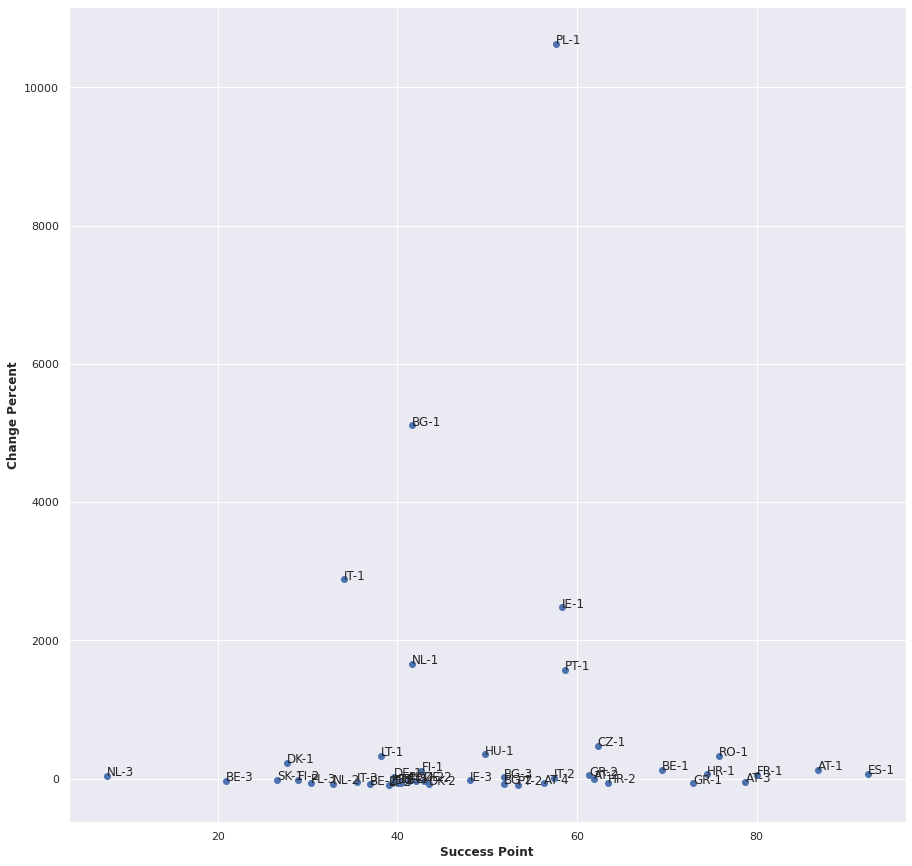

In [54]:
plt.figure(figsize=(15, 15))
y = [lockdown.get_change_percent() for lockdown in lockdowns]
x = [lockdown.fixed_success_point for lockdown in lockdowns]
z = []
lastest_dict = {}
for lockdown in lockdowns:
    if lockdown.country_code in lastest_dict:
        lastest_dict[lockdown.country_code] = lastest_dict[lockdown.country_code] + 1
    else:
        lastest_dict[lockdown.country_code] = 1
    lockdown.lockdown_name = "{}-{}".format(lockdown.country_code, lastest_dict[lockdown.country_code])
    z.append(lockdown.lockdown_name)

mean_x = statistics.mean(x)
mean_y = statistics.mean(y)
min_y = min(y)
max_y = max(y)
min_x = min(x)
max_x = max(x)

plt.scatter(x, y)
plt.xlabel('Success Point',
               fontweight ='bold')
plt.ylabel('Change Percent',
               fontweight ='bold')
for country_code, success, change in zip(z, x, y):
    plt.annotate(country_code, (success, change))
plt.show()

(Grafikte yer alan kapanmalar $ ülke $ $ kodu $ $ - $ $ kaçıncı $ $ kapanması $ $ olduğu $ şeklinde kodlanmıştır.)

Bu grafiği incelediğimizde, ülkelerin kapanma dönemlerinde hareketlilik değişiminde yüksek oranda hareketliliği azaltmasının ilk kapanma dönemlerinde vaka sayısına etkisinin ilerleyen dönemlere kıyasla daha düşük olduğunu gözlemledik. Çünkü salgının ilk dönemlerinde insanlar hareketliliği azaltsa bile verimli bir kapanmanın nasıl yapılacağını bilmiyordu bu yüzden ilk kapanmalarda hareketlilik yüksek oranda azalsa bile vaka sayılarında yüksek oranda artışlar olabiliyordu. Ülkelerin daha sonraki kapanmalarında hareketliliği azaltma başarısı daha düşük olsa bile vaka sayısının daha yüksek oranda azaltabilmesinin sebebi insanların kapanma yapmak konusunda daha bilinçli olmasıydı.

Bu grafik hakkında yaptığımız yorumlar bizim için yeterli değildi. Biz daha çok elimizdeki kapanmalara bir başarı sonucu vermek istiyorduk. Bunun için grafiğimizdeki noktaları sınıflandırmaya karar verdik. 

Classification yöntemlerini araştırdıktan sonra Decision Tree kullanmanın verimize en uygun yöntem olacağını düşündük. 

İşleme geçmeden outlier olan verileri işlemden çıkartarak grafiğimizi yeniden çizdirdik. Çünkü outlier değerler verimizde bozulmalara yol açabilirdi. Grafiğimizin son hali aşağıdaki gibidir: 

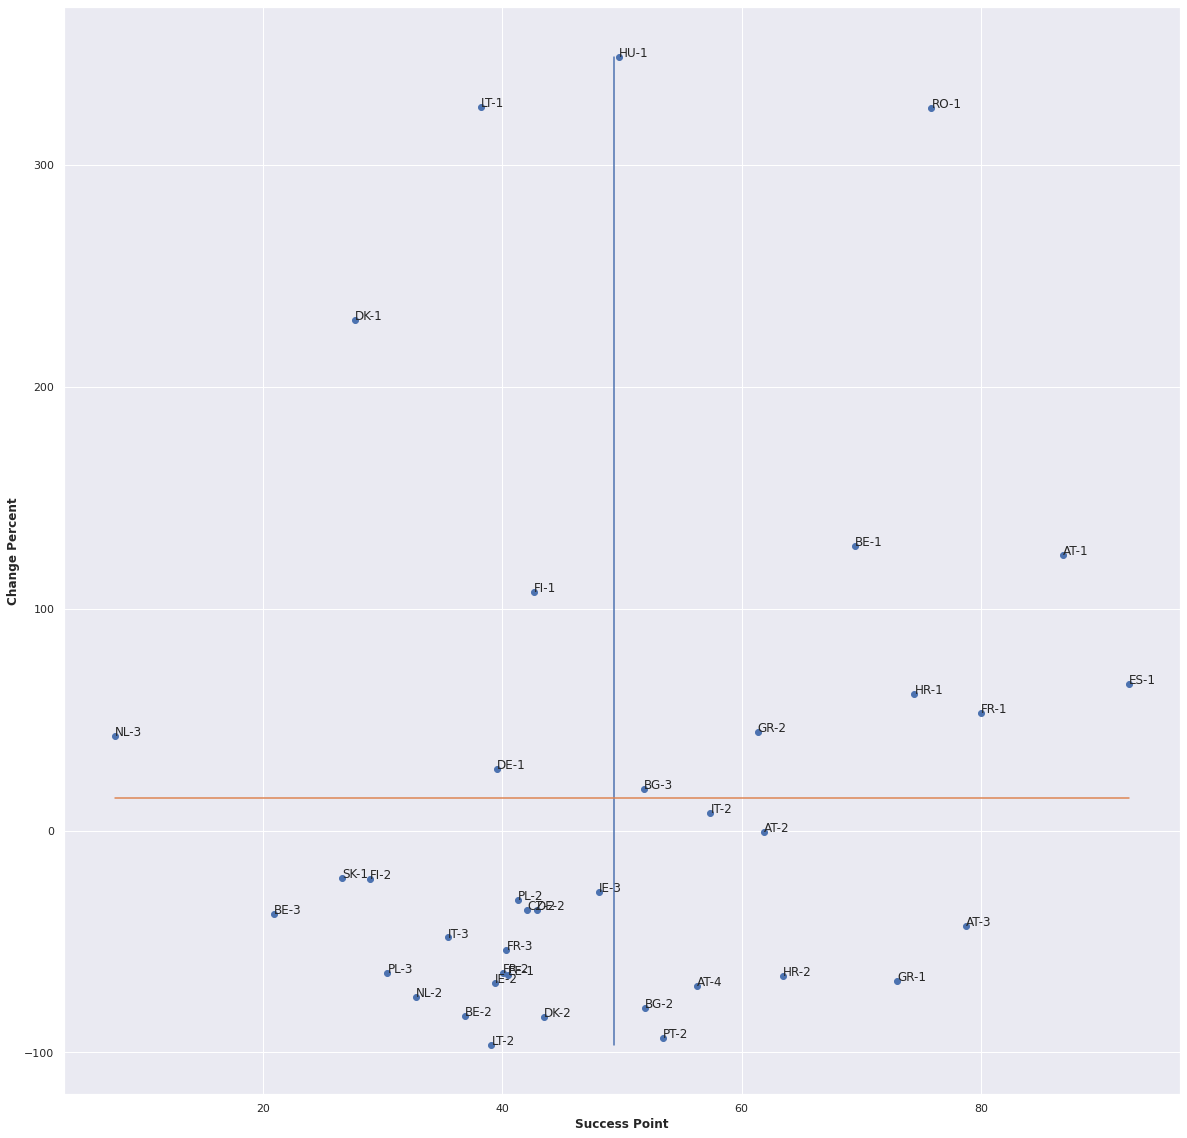

In [55]:
plt.figure(figsize=(20, 20))
x = [lockdown.get_change_percent() for lockdown in lockdowns]
y = [lockdown.fixed_success_point for lockdown in lockdowns]
z = [lockdown.lockdown_name for lockdown in lockdowns]
t = [lockdown.lockdown_start_date for lockdown in lockdowns]
t2 = [lockdown.lockdown_end_date for lockdown in lockdowns]
df = pd.DataFrame(list(zip(y, x)), columns=["success", "change percent"])
df2 = pd.DataFrame(list(zip(y, z, t, t2)), columns=["change percent", "country_code", "start_date", "end_date"])

Q1 = np.percentile(df['change percent'], 25, interpolation = 'midpoint')
Q3 = np.percentile(df['change percent'], 75, interpolation = 'midpoint')

IQR = Q3 - Q1

upper = np.where(df['change percent'] >= (Q3+1.5*IQR))
lower = np.where(df['change percent'] <= (Q1-1.5*IQR))

df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)
df2.drop(upper[0], inplace = True)
df2.drop(lower[0], inplace=True)

mean_y = df['change percent'].mean()
min_y = df['change percent'].min()
max_y = df['change percent'].max()
mean_x = df['success'].mean()
min_x = df['success'].min()
max_x = df['success'].max()

plt.plot((mean_x, mean_x), (min_y, max_y))
plt.plot((min_x, max_x), (mean_y, mean_y))
plt.scatter(df['success'], df['change percent'])
plt.xlabel('Success Point',
               fontweight ='bold')
plt.ylabel('Change Percent',
               fontweight ='bold')
for country_code, success, change in zip(df2['country_code'], df['success'], df['change percent']):
    plt.annotate(country_code, (success, change))
plt.show()

Tüm bu işlemler sonucu classification yapmaya uygun bir veri grubu elde ettik.

Decision Tree için gerekli olan train datayı aşağıdaki şekilde hazırladık:

| Success | Change Percent | Label |
| :- | :- | :- |
| 60 | 80 | kötü |
| 30 | 50 | kötü |
| 70 | -35 | iyi |
| 20 | -40 | orta |
| 45 | 30 | kötü |
| 50 | -40 | iyi |
| 50 | 5 | orta |
| 80 | 20 | orta |
| 40 | -15 | iyi |

Bu veriler eşliğinde decision tree oluşturmuş olduk.

Bundan sonra yapmamız gereken Decision Tree için dallanmaları düzenlemekti. Bunu da aşağıdaki gibi yaptık:

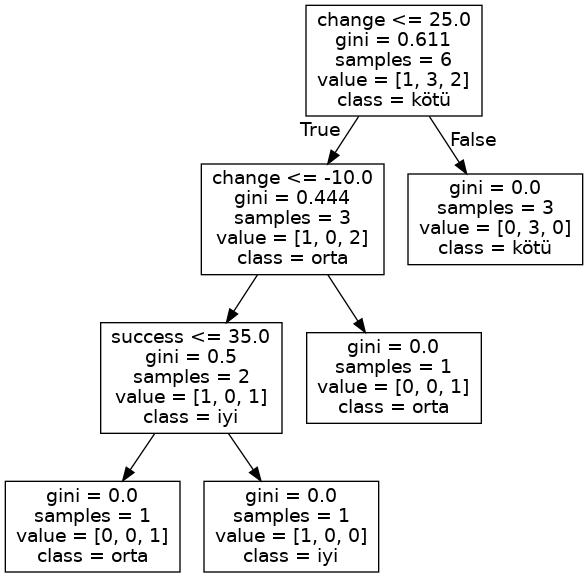

In [56]:
x = [lockdown.get_change_percent() for lockdown in lockdowns]
y = [lockdown.fixed_success_point for lockdown in lockdowns]
z = [lockdown.lockdown_name for lockdown in lockdowns]
train_df = pd.read_csv("train_data.csv")
X = train_df[["success", "change percent"]]
Y = train_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

dt = DecisionTreeClassifier()
clf = dt.fit(X_train, y_train)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, feature_names=["success", "change"], class_names=['iyi', 'kötü', 'orta'])
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

<Figure size 720x720 with 0 Axes>

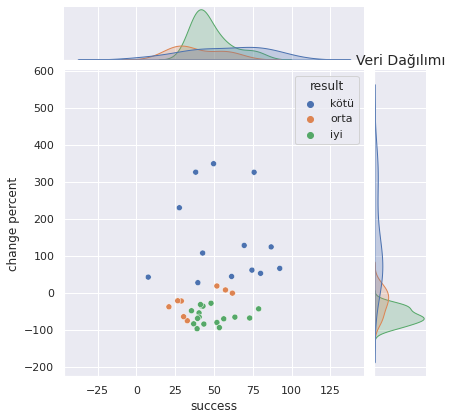

In [57]:
plt.figure(figsize=(10, 10))
y_predict = clf.predict(df)
df['result'] = y_predict
sns.jointplot(x="success", y="change percent",
           hue="result", data=df)
plt.xlabel("Success", fontsize=12)
plt.ylabel("Change percent", fontsize=12)
plt.title("Veri Dağılımı", fontsize=14)
plt.show()

In [58]:
df['lockdown_code'] = df2['country_code']
df['lockdown_start_date'] = df2['start_date']
df['lockdown_end_date'] = df2['end_date']
df.reset_index(inplace=True)
print(df)

    index    success  change percent result lockdown_code lockdown_start_date  \
0       0  86.835296      124.292453   kötü          AT-1          2020-03-16   
1       1  61.860207       -0.578735   orta          AT-2          2020-11-03   
2       2  78.763719      -42.999106    iyi          AT-3          2020-12-26   
3       3  56.276987      -69.916648    iyi          AT-4          2021-11-22   
4       4  69.453993      128.276421   kötü          BE-1          2020-03-18   
5       5  36.905811      -83.462260    iyi          BE-2          2020-11-02   
6       6  20.935553      -37.481203   orta          BE-3          2021-03-27   
7       8  51.899878      -79.878885    iyi          BG-2          2020-11-28   
8       9  51.862859       18.715892   orta          BG-3          2021-03-22   
9      10  74.439513       61.637931   kötü          HR-1          2020-03-18   
10     11  63.465364      -65.334711    iyi          HR-2          2020-12-22   
11     13  42.075677      -3